# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: Новокрещенова Ольга Ростиславна

Группа: MADE-DS-12

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

In [1]:
import numpy as np
from math import radians, cos, sin, asin, sqrt
from shapely import geometry
from shapely.geometry import Point, Polygon, LineString, MultiPolygon
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
import folium
from folium import plugins
import pandas as pd
import json
import requests
from openrouteservice import client
import pyproj
from pyproj import Transformer

areaId:  3600303427
Center:  [33.9341341, 67.7037327]
Shape: 


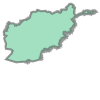

In [2]:
nominatim = Nominatim()
overpass = Overpass()

areaId = nominatim.query('Afganistan').areaId()

query = overpassQueryBuilder(area=areaId, elementType=['rel'], selector='"admin_level"= "2"', out='geom')
result = overpass.query(query, timeout = 900)
polygon = result.relations()[0].geometry()
pl = Polygon(polygon['coordinates'][0])

query = overpassQueryBuilder(area=areaId, elementType=['rel'], selector='"admin_level"= "2"', out='center')
result = overpass.query(query, timeout = 900)
cntr = result.toJSON()['elements'][0]['center']
af_center = [float(cntr['lat']), float(cntr['lon'])]

print('areaId: ', areaId)
print('Center: ', af_center)
print('Shape: ')
pl

In [3]:
def haversine(lon1, lat1, lon2, lat2): 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371
    return c * r

def dist (point1, point2):
    return haversine(point1[1], point1[0], point2[1], point2[0])

def randpoint (box):
    x = np.random.uniform(box[0][1], box[1][1])
    y = np.random.uniform(box[0][0], box[1][0])
    return [y,x]

def newbox (center, size):
    stepy = abs(size / dist(center, [0, center[1]]) * center[0])
    stepx = abs(size / dist(center, [center[0], 0]) * center[1])
    x1 = center[1] - stepx
    if x1 < -180:
        x1 = -180
    x2 = center[1] + stepx
    if x2 > 180:
        x2 = 180
    y1 = center[0] - stepy
    if y1 < -90:
        y1 = -90
    y2 = center[0] + stepy
    if y2 > 90:
        y2 = 90
    return [[y1,x1],[y2,x2]]

curdist = 100000000
points = []
boxes = []
boxes.append([[-90,-180],[90,180]])

finish = False

while not finish:
    box = boxes[-1]
    rp = randpoint(box)
    pt = Point(rp[1], rp[0])
    d = dist(af_center, rp)
    col = 'red'
    if d < curdist:
        curdist = d
        boxes.append(newbox(rp, d))
        col = 'blue'
    if pl.contains(pt):
        col = 'green'
        finish = True
    points.append([rp, box, col])

print ("Finished at attempt number {}".format(len(points)))

Finished at attempt number 12


In [4]:
m = folium.Map()
folium.GeoJson(polygon).add_to(m)
folium.Marker(af_center, popup='<b>Afganistan center</b>').add_to(m)
for i in range(len(points)):
    pt = points[i][0]
    box = points[i][1]
    col = points[i][2]
    icon = plugins.BeautifyIcon(
        number = i,
        border_color = col,
        text_color = col,
        inner_icon_style = 'margin-top:0;')
    folium.Marker(pt, popup = 'lat: {}, lon: {}'.format(points[i][0][0], points[i][0][1]), icon = icon).add_to(m)
    folium.Rectangle(box).add_to(m)
m


Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

In [ ]:
# put your code here

overpass = Overpass()

result = overpass.query('relation["admin_level"="2"];out ids;',  timeout = 900)
countriesID = result.toJSON()
listID = []
for rel in countriesID['elements']:
    countryID = rel['id']
    if countryID % 10 == 0:
        listID.append(countryID)
        
print(listID)

In [ ]:
apartments = []
for country_id in listID:
    query = overpassQueryBuilder(area=country_id, elementType=['node', 'way','rel'], selector='landuse=residential', out='count')
    print(query)
    apartments.append(overpass.query(query, timeout=900).countElements())

In [ ]:
pharmacies = []
for country_id in listID:
    query = overpassQueryBuilder(area=country_id, elementType=['node', 'way','rel'], selector='admin_center = 2', out ids)
    capital = overpass.query(r:"admin_centre", timeout=900)
    query = overpassQueryBuilder(area=capital, elementType=['node', 'way','rel'], selector='amenity=pharmacy', out='count')
    pharmacies.append(overpass.query(query, timeout=900).countElements())

In [ ]:
print(pharmacies)

## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [5]:
# put your code here
schools = json.loads(requests.get(f'https://data.cityofnewyork.us/resource/a3nt-yts4.json').text)
nyc_map = folium.Map(location = [40.7401651, -73.9863046], zoom_start = 12)
folium.Marker([40.7753803, -73.9650045], popup='<b>From</b>', icon=folium.Icon(color='green', icon='car', prefix='fa')).add_to(nyc_map)
folium.Marker([40.7032012, -73.9895800], popup='<b>To</b>', icon=folium.Icon(color='red', icon='car', prefix='fa')).add_to(nyc_map)
nyc_map

In [6]:
api_key = '5b3ce3597851110001cf62488fb4410bc4bb4e759ae833fd192bf66a' # Individual api key
clnt = client.Client(key=api_key)

def CreateBufferPolygon(point_in, resolution=10, radius=10):    
     
    transformerto = Transformer.from_crs("epsg:4326", "epsg:32632", always_xy=True)
    transformerfrom = Transformer.from_crs("epsg:32632", "epsg:4326", always_xy=True)
    point_in_proj = transformerto.transform(*point_in)
    point_buffer_proj = Point(point_in_proj).buffer(radius, resolution=resolution) # buffer
    
    # Iterate over all points in buffer and build polygon
    poly_wgs = []
    for point in point_buffer_proj.exterior.coords:
        poly_wgs.append(transformerfrom.transform(*point))
         
    return poly_wgs

In [7]:
schools_poly = []
for schools_data in schools:
    schools_coords = schools_data['the_geom']['coordinates']
    schools_poly_coords = CreateBufferPolygon(schools_coords, resolution=2, radius=150)
    schools_poly.append(schools_poly_coords)    

In [8]:
request_params = {'coordinates': [[-73.9650045, 40.7753803], [-73.9895800, 40.7032012]],
                'format_out': 'geojson',
                'profile': 'driving-car',}

route_normal = clnt.directions(**request_params)
route_buffer = LineString(route_normal['features'][0]['geometry']['coordinates']).buffer(0.05)
folium.features.GeoJson(data=geometry.mapping(route_buffer), name='Route Buffer', overlay=True).add_to(nyc_map)

schools_buffer_poly = []
for school_poly in schools_poly:
    poly = Polygon(school_poly)
    if route_buffer.intersects(poly):
        folium.features.Marker(list(reversed(poly.centroid.coords[0])), icon=folium.Icon(color='lightgray', icon='graduation-cap', prefix='fa')).add_to(nyc_map)
        schools_buffer_poly.append(poly)
        school_poly_coords_folium = [(y,x) for x,y in school_poly]
        folium.vector_layers.Polygon(locations=school_poly_coords_folium,
                                  color='#ffd699',
                                  fill_color='#ffd699',
                                  fill_opacity=0.2,
                                  weight=3).add_to(nyc_map)
          
nyc_map

In [9]:
schools_buffer_poly
request_params['options'] = {'avoid_polygons': geometry.mapping(MultiPolygon(schools_buffer_poly))}
route_detour = clnt.directions(**request_params)
folium.features.GeoJson(data=route_detour, overlay=True).add_to(nyc_map)

nyc_map
